### Install dependencies (A2A + ADK + MCP server deps)

In [1]:
!pip install --upgrade -q \
  google-genai \
  google-adk==1.9.0 \
  a2a-sdk==0.3.0 \
  python-dotenv \
  aiohttp \
  uvicorn \
  requests \
  nest-asyncio \
  flask \
  flask-cors \
  termcolor \
  pyngrok

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.8/46.8 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.3/130.3 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.5/260.5 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 4.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.


### Set up environment (API key, project, etc.)

In [2]:
import os, sys, logging
from dotenv import load_dotenv

load_dotenv()

# 1) Force use of API key instead of Vertex if you prefer Aistudio key
os.environ["GOOGLE_GENAI_USE_VERTEXAI"] = "FALSE"

# 2) GCP project/location – adjust to your own
os.environ["GOOGLE_CLOUD_PROJECT"] = "gen-lang-client-0731702882"
os.environ["GOOGLE_CLOUD_LOCATION"] = "us-central1"

print("Environment variables configured:")
print("GOOGLE_GENAI_USE_VERTEXAI:", os.environ["GOOGLE_GENAI_USE_VERTEXAI"])
print("GOOGLE_CLOUD_PROJECT:", os.environ["GOOGLE_CLOUD_PROJECT"])
print("GOOGLE_CLOUD_LOCATION:", os.environ["GOOGLE_CLOUD_LOCATION"])

# 3) Google API key + MCP URL from Colab Secrets (pattern from lg_adk_customer_agent)
from google.colab import userdata
from termcolor import colored

try:
    GOOGLE_API_KEY = userdata.get("GOOGLE_API_KEY")
    os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY
    print(colored("✅ Google API Key loaded", "green"))
except Exception:
    print(colored("❌ GOOGLE_API_KEY not found in secrets", "red"))
    print(colored("   Please add it in Colab 🔑 Secrets", "yellow"))
    raise

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(name)s - %(message)s",
)

Environment variables configured:
GOOGLE_GENAI_USE_VERTEXAI: FALSE
GOOGLE_CLOUD_PROJECT: gen-lang-client-0731702882
GOOGLE_CLOUD_LOCATION: us-central1
✅ Google API Key loaded


### Initialize the database (using database_setup.py)

In [3]:
from database_setup import DatabaseSetup

db = DatabaseSetup("support.db")

db.connect()            # open DB
db.create_tables()      # create customers + tickets tables
db.create_triggers()    # create updated_at trigger
db.insert_sample_data() # insert the sample customers + tickets
db.run_sample_queries() # optional: just to see example outputs
db.close()              # close DB connection

Connected to database: support.db
Tables created successfully!
Triggers created successfully!
Sample data inserted successfully!
  - 15 customers added
  - 25 tickets added

SAMPLE QUERIES

1. All Open Tickets:
------------------------------------------------------------
  Ticket #1 | John Doe             | HIGH   | Cannot login to account
  Ticket #3 | Edward Norton        | HIGH   | Payment processing failing for all transactions
  Ticket #8 | Charlie Brown        | MEDIUM | Email notifications not being received
  Ticket #10 | George Miller        | MEDIUM | Export to CSV feature broken
  Ticket #13 | Michael Scott        | MEDIUM | API rate limiting too restrictive
  Ticket #15 | Jane Smith           | LOW    | Feature request: dark mode
  Ticket #16 | Bob Johnson          | LOW    | Documentation outdated for API v2
  Ticket #18 | Diana Prince         | LOW    | Request for additional language support
  Ticket #20 | Isaac Newton         | LOW    | Feature request: export to PDF
  

### Implement MCP server with the required 5 tools

I’ll reuse the MCP pattern from lg_mcp_customer_demo, but implement only the tools the assignment wants:

- get_customer(customer_id)

- list_customers(status, limit)

- update_customer(customer_id, data)

- create_ticket(customer_id, issue, priority)

- get_customer_history(customer_id)

### Imports and globals

In [4]:
import sqlite3
import json
import threading
import time
from typing import Dict, Any, List

from flask import Flask, request, Response, jsonify
from flask_cors import CORS
from termcolor import colored
from pyngrok import ngrok
from google.colab import userdata

DB_PATH = "support.db"
SERVER_HOST = "127.0.0.1"
SERVER_PORT = 5000
SERVER_URL = f"http://{SERVER_HOST}:{SERVER_PORT}"

app = Flask(__name__)
CORS(app)

server_thread = None
server_running = False

### DB helper

In [5]:
def get_db_connection():
    conn = sqlite3.connect(DB_PATH)
    conn.row_factory = sqlite3.Row
    return conn

### Tool implementations (DB logic)

In [6]:
def get_customer(customer_id: int) -> Dict[str, Any]:
    conn = get_db_connection()
    cursor = conn.cursor()
    try:
        cursor.execute("SELECT * FROM customers WHERE id = ?", (customer_id,))
        row = cursor.fetchone()
        if not row:
            return {"success": False, "error": f"Customer {customer_id} not found"}

        return {
            "success": True,
            "customer": dict(row),
        }
    finally:
        conn.close()


def list_customers(status: str = None, limit: int = 10) -> Dict[str, Any]:
    conn = get_db_connection()
    cursor = conn.cursor()
    try:
        if status:
            cursor.execute(
                "SELECT * FROM customers WHERE status = ? ORDER BY id LIMIT ?",
                (status, limit),
            )
        else:
            cursor.execute(
                "SELECT * FROM customers ORDER BY id LIMIT ?", (limit,)
            )
        rows = cursor.fetchall()
        return {
            "success": True,
            "customers": [dict(r) for r in rows],
        }
    finally:
        conn.close()


def update_customer(customer_id: int, data: Dict[str, Any]) -> Dict[str, Any]:
    if not data:
        return {"success": False, "error": "No fields provided to update"}

    allowed_fields = {"name", "email", "phone", "status"}
    updates = []
    values = []
    for k, v in data.items():
        if k in allowed_fields:
            updates.append(f"{k} = ?")
            values.append(v)

    if not updates:
        return {"success": False, "error": "No valid fields to update"}

    conn = get_db_connection()
    cursor = conn.cursor()
    try:
        values.append(customer_id)
        cursor.execute(
            f"UPDATE customers SET {', '.join(updates)}, updated_at = CURRENT_TIMESTAMP WHERE id = ?",
            values,
        )
        conn.commit()

        cursor.execute("SELECT * FROM customers WHERE id = ?", (customer_id,))
        row = cursor.fetchone()
        if not row:
            return {"success": False, "error": f"Customer {customer_id} not found after update"}

        return {"success": True, "customer": dict(row)}
    finally:
        conn.close()


def create_ticket(customer_id: int, issue: str, priority: str = "medium") -> Dict[str, Any]:
    if priority not in ("low", "medium", "high"):
        return {"success": False, "error": "priority must be low|medium|high"}

    conn = get_db_connection()
    cursor = conn.cursor()
    try:
        # verify customer exists
        cursor.execute("SELECT id FROM customers WHERE id = ?", (customer_id,))
        if not cursor.fetchone():
            return {"success": False, "error": f"Customer {customer_id} not found"}

        cursor.execute(
            """
            INSERT INTO tickets (customer_id, issue, status, priority)
            VALUES (?, ?, 'open', ?)
            """,
            (customer_id, issue, priority),
        )
        conn.commit()
        ticket_id = cursor.lastrowid

        cursor.execute("SELECT * FROM tickets WHERE id = ?", (ticket_id,))
        row = cursor.fetchone()
        return {"success": True, "ticket": dict(row)}
    finally:
        conn.close()


def get_customer_history(customer_id: int) -> Dict[str, Any]:
    conn = get_db_connection()
    cursor = conn.cursor()
    try:
        # basic customer info
        cursor.execute("SELECT * FROM customers WHERE id = ?", (customer_id,))
        cust = cursor.fetchone()
        if not cust:
            return {"success": False, "error": f"Customer {customer_id} not found"}

        # tickets
        cursor.execute(
            "SELECT * FROM tickets WHERE customer_id = ? ORDER BY created_at DESC",
            (customer_id,),
        )
        tickets = cursor.fetchall()

        return {
            "success": True,
            "customer": dict(cust),
            "tickets": [dict(t) for t in tickets],
        }
    finally:
        conn.close()

def search_tickets(priority=None, status=None, customer_status=None):
    conn = get_db_connection()
    cursor = conn.cursor()
    try:
        query = """
            SELECT t.*, c.name AS customer_name, c.status AS customer_status
            FROM tickets t
            JOIN customers c ON c.id = t.customer_id
            WHERE 1=1
        """
        params = []

        if priority:
            query += " AND t.priority = ?"
            params.append(priority)

        if status:
            query += " AND t.status = ?"
            params.append(status)

        if customer_status:
            query += " AND c.status = ?"
            params.append(customer_status)

        query += " ORDER BY t.created_at DESC"

        cursor.execute(query, params)
        rows = cursor.fetchall()

        return {"success": True, "tickets": [dict(r) for r in rows]}

    finally:
        conn.close()

### MCP tool schemas (MCP_TOOLS): This mirrors the MCP_TOOLS block in lg_mcp_customer_demo, but only for our tools.

In [7]:
MCP_TOOLS: List[Dict[str, Any]] = [
    {
        "name": "get_customer",
        "description": "Get a single customer by ID.",
        "inputSchema": {
            "type": "object",
            "properties": {
                "customer_id": {
                    "type": "integer",
                    "description": "Customer ID (customers.id)",
                }
            },
            "required": ["customer_id"],
        },
    },
    {
        "name": "list_customers",
        "description": "List customers, optionally filtered by status.",
        "inputSchema": {
            "type": "object",
            "properties": {
                "status": {
                    "type": "string",
                    "enum": ["active", "disabled"],
                    "description": "Filter by customer status (optional)",
                },
                "limit": {
                    "type": "integer",
                    "minimum": 1,
                    "maximum": 100,
                    "default": 10,
                    "description": "Max number of customers to return",
                },
            },
        },
    },
    {
        "name": "update_customer",
        "description": "Update an existing customer fields.",
        "inputSchema": {
            "type": "object",
            "properties": {
                "customer_id": {
                    "type": "integer",
                    "description": "Target customers.id",
                },
                "data": {
                    "type": "object",
                    "description": "Fields to update",
                    "properties": {
                        "name": {"type": "string"},
                        "email": {"type": "string"},
                        "phone": {"type": "string"},
                        "status": {
                            "type": "string",
                            "enum": ["active", "disabled"],
                        },
                    },
                },
            },
            "required": ["customer_id", "data"],
        },
    },
    {
        "name": "create_ticket",
        "description": "Create a new support ticket for a customer.",
        "inputSchema": {
            "type": "object",
            "properties": {
                "customer_id": {
                    "type": "integer",
                    "description": "customers.id",
                },
                "issue": {
                    "type": "string",
                    "description": "Issue description",
                },
                "priority": {
                    "type": "string",
                    "enum": ["low", "medium", "high"],
                    "default": "medium",
                },
            },
            "required": ["customer_id", "issue"],
        },
    },
    {
        "name": "get_customer_history",
        "description": "Get a customer plus all their tickets.",
        "inputSchema": {
            "type": "object",
            "properties": {
                "customer_id": {
                    "type": "integer",
                    "description": "customers.id",
                }
            },
            "required": ["customer_id"],
        },
    },
    {
    "name": "search_tickets",
    "description": "Search tickets by priority, ticket status, and/or customer status.",
    "inputSchema": {
        "type": "object",
        "properties": {
            "priority": {
                "type": "string",
                "enum": ["low", "medium", "high"],
                "description": "Filter by ticket priority (optional)"
            },
            "status": {
                "type": "string",
                "enum": ["open", "in_progress", "resolved"],
                "description": "Filter by ticket status (optional)"
            },
            "customer_status": {
                "type": "string",
                "enum": ["active", "disabled"],
                "description": "Filter by customer status (optional)"
            }
        }
    }
}
]

### MCP message handlers (initialize, tools/list, tools/call): Pattern taken directly from lg_mcp_customer_demo

In [8]:
def handle_initialize(message: Dict[str, Any]) -> Dict[str, Any]:
    return {
        "jsonrpc": "2.0",
        "id": message.get("id"),
        "result": {
            "protocolVersion": "2024-11-05",
            "capabilities": {"tools": {}},
            "serverInfo": {
                "name": "customer-support-mcp-server",
                "version": "1.0.0",
            },
        },
    }


def handle_tools_list(message: Dict[str, Any]) -> Dict[str, Any]:
    return {
        "jsonrpc": "2.0",
        "id": message.get("id"),
        "result": {
            "tools": MCP_TOOLS,
        },
    }


def handle_tools_call(message: Dict[str, Any]) -> Dict[str, Any]:
    params = message.get("params", {})
    tool_name = params.get("name")
    arguments = params.get("arguments", {}) or {}

    tool_functions = {
        "get_customer": get_customer,
        "list_customers": list_customers,
        "update_customer": update_customer,
        "create_ticket": create_ticket,
        "get_customer_history": get_customer_history,
        "search_tickets": search_tickets,
    }

    if tool_name not in tool_functions:
        return {
            "jsonrpc": "2.0",
            "id": message.get("id"),
            "error": {
                "code": -32601,
                "message": f"Tool not found: {tool_name}",
            },
        }

    try:
        result = tool_functions[tool_name](**arguments)
        return {
            "jsonrpc": "2.0",
            "id": message.get("id"),
            "result": {
                "content": [
                    {
                        "type": "text",
                        "text": json.dumps(result, indent=2),
                    }
                ]
            },
        }
    except Exception as e:
        return {
            "jsonrpc": "2.0",
            "id": message.get("id"),
            "error": {
                "code": -32000,
                "message": f"Tool execution error: {str(e)}",
            },
        }

### MCP message dispatcher + Flask /mcp endpoint (with SSE), /health

In [9]:
def process_mcp_message(message: Dict[str, Any]) -> Dict[str, Any]:
    method = message.get("method")
    if method == "initialize":
        return handle_initialize(message)
    elif method == "tools/list":
        return handle_tools_list(message)
    elif method == "tools/call":
        return handle_tools_call(message)
    else:
        return {
            "jsonrpc": "2.0",
            "id": message.get("id"),
            "error": {
                "code": -32601,
                "message": f"Unsupported method: {method}",
            },
        }


def create_sse_message(payload: Dict[str, Any]) -> str:
    return f"data: {json.dumps(payload)}\n\n"


@app.route("/mcp", methods=["POST"])
def mcp_endpoint():
    message = request.get_json()

    def generate():
        try:
            print(f"📥 Received MCP method: {message.get('method')}")
            response = process_mcp_message(message)
            yield create_sse_message(response)
        except Exception as e:
            error_response = {
                "jsonrpc": "2.0",
                "id": None,
                "error": {"code": -32700, "message": f"Parse error: {str(e)}"},
            }
            yield create_sse_message(error_response)

    return Response(generate(), mimetype="text/event-stream")


@app.route("/health", methods=["GET"])
def health_check():
    return jsonify(
        {
            "status": "healthy",
            "server": "customer-support-mcp-server",
            "version": "1.0.0",
        }
    )

### Start server + ngrok (background thread, same pattern as lg_mcp_customer_demo)

In [10]:
def run_server():
    global server_running
    server_running = True
    app.run(host=SERVER_HOST, port=SERVER_PORT, debug=False, use_reloader=False)


def start_server(use_ngrok: bool = True):
    global server_thread, server_running

    if server_thread and server_thread.is_alive():
        print(colored("⚠️ Server already running", "yellow"))
        return

    print(colored("🚀 Starting MCP server...", "cyan"))
    server_thread = threading.Thread(target=run_server, daemon=True)
    server_thread.start()

    # Wait until /health responds
    import requests

    for _ in range(30):
        try:
            r = requests.get(f"{SERVER_URL}/health", timeout=1.0)
            if r.status_code == 200:
                print(colored(f"✅ MCP server healthy at {SERVER_URL}", "green"))
                break
        except Exception:
            pass
        time.sleep(1.0)

    # Ngrok
    if use_ngrok:
        print(colored("\n🌐 Setting up ngrok tunnel...", "cyan"))
        try:
            authtoken = userdata.get("NGROK_AUTHTOKEN")
            ngrok.set_auth_token(authtoken)
            public_url = ngrok.connect(SERVER_PORT)
            public_url = str(public_url)
            print(colored(f"✅ Public URL: {public_url}", "green", attrs=["bold"]))
            print(colored(f"📍 MCP Endpoint: {public_url}/mcp", "green", attrs=["bold"]))
            print(colored(f"📍 Health Check: {public_url}/health", "cyan"))

            print(colored("\n➡️  Save this URL as MCP_SERVER_URL in Colab Secrets", "yellow"))
        except Exception as e:
            print(colored("⚠️ Could not set up ngrok", "yellow"))
            print(e)

In [11]:
start_server(use_ngrok=True)

🚀 Starting MCP server...
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [20/Nov/2025 18:31:58] "GET /health HTTP/1.1" 200 -


✅ MCP server healthy at http://127.0.0.1:5000

🌐 Setting up ngrok tunnel...
✅ Public URL: NgrokTunnel: "https://5a9b9ccaf8f2.ngrok-free.app" -> "http://localhost:5000"
📍 MCP Endpoint: NgrokTunnel: "https://5a9b9ccaf8f2.ngrok-free.app" -> "http://localhost:5000"/mcp
📍 Health Check: NgrokTunnel: "https://5a9b9ccaf8f2.ngrok-free.app" -> "http://localhost:5000"/health

➡️  Save this URL as MCP_SERVER_URL in Colab Secrets


### Customer Data Agent (ADK + MCPToolset) = “Customer Data Agent (Specialist)”: Now I reuse the pattern in lg_adk_customer_agent, but be explicit that this agent is the Customer Data Agent.

In [12]:
from termcolor import colored
from google.colab import userdata
import os

from google.adk.agents import LlmAgent
from google.adk.tools.mcp_tool import MCPToolset, StreamableHTTPConnectionParams

MCP_SERVER_URL = userdata.get("MCP_SERVER_URL")
print(colored(f"✅ MCP_SERVER_URL: {MCP_SERVER_URL}", "green"))

customer_data_agent = LlmAgent(
    model="gemini-2.5-flash",
    name="customer_data_agent",
    description="""
You are the Customer Data Agent.

You ONLY interact with the customer database via MCP tools:
- get_customer(customer_id)
- list_customers(status, limit)
- update_customer(customer_id, data)
- create_ticket(customer_id, issue, priority)
- get_customer_history(customer_id)
- search_tickets(priority, status, customer_status)

Responsibilities:
- Retrieve and validate customer data.
- Update fields when asked.
- Create tickets and return IDs.
- Fetch and summarize customer history.
- Perform advanced ticket searches using search_tickets.

Always:
- Describe which MCP tools you used.
- Return structured summaries that other agents can reuse.
""",
    tools=[
        MCPToolset(
            connection_params=StreamableHTTPConnectionParams(
                url=MCP_SERVER_URL
            )
        )
    ],
)

print(colored("💡 Customer Data Agent ready (via MCP).", "yellow"))

/usr/local/lib/python3.12/dist-packages/google/cloud/aiplatform/models.py:52: FutureWarning: Support for google-cloud-storage < 3.0.0 will be removed in a future version of google-cloud-aiplatform. Please upgrade to google-cloud-storage >= 3.0.0.
  from google.cloud.aiplatform.utils import gcs_utils


✅ MCP_SERVER_URL: https://5a9b9ccaf8f2.ngrok-free.app/mcp
💡 Customer Data Agent ready (via MCP).


### Support Agent (Specialist) – general customer support

In [13]:
from google.adk.agents import LlmAgent

support_agent = LlmAgent(
    model="gemini-2.5-flash",
    name="support_agent",
    description="""
You are the Support Agent.

Your responsibilities:
- Handle general customer support questions.
- For billing, cancellation, or escalation cases, you may need context from the Customer Data Agent (sent via the Router).
- You NEVER call MCP tools directly.
- You expect the Router to give you the customer information you need.

When responding:
- Always use the context passed from the Router/Data Agent.
- Clearly state when something is urgent or escalated.
- Be concise, friendly, and action-oriented.
"""
)

print(colored("💡 Support Agent ready.", "yellow"))

💡 Support Agent ready.


### Wrap agents as A2A servers (using LG_a2a_quickstart): Now I directly reuse the A2A server pattern from lg_a2a_quickstart

### Import A2A helpers from LG_a2a_quickstart

In [14]:
# Install required packages
%pip install --upgrade -q google-genai google-adk==1.9.0 a2a-sdk==0.3.0 python-dotenv aiohttp uvicorn requests mermaid-python nest-asyncio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 21.6 MB/s eta 0:00:00


In [15]:
# Targeted workaround for google-adk==1.9.0 compatibility with a2a-sdk==0.3.0
# This cell shall be removed when google-adk releases the version next to >1.9.0
# (after https://github.com/google/adk-python/pull/2297)


import sys

from a2a.client import client as real_client_module
from a2a.client.card_resolver import A2ACardResolver


class PatchedClientModule:
    def __init__(self, real_module) -> None:
        for attr in dir(real_module):
            if not attr.startswith('_'):
                setattr(self, attr, getattr(real_module, attr))
        self.A2ACardResolver = A2ACardResolver


patched_module = PatchedClientModule(real_client_module)
sys.modules['a2a.client.client'] = patched_module  # type: ignore

In [16]:
import asyncio
import logging
import os
import sys
import threading
import time

from typing import Any

import httpx
import nest_asyncio
import uvicorn

from a2a.client import ClientConfig, ClientFactory, create_text_message_object
from a2a.server.apps import A2AStarletteApplication
from a2a.server.request_handlers import DefaultRequestHandler
from a2a.server.tasks import InMemoryTaskStore
from a2a.types import (
    AgentCapabilities,
    AgentCard,
    AgentSkill,
    TransportProtocol,
)
from a2a.utils.constants import AGENT_CARD_WELL_KNOWN_PATH
from dotenv import load_dotenv
from google.adk.a2a.executor.a2a_agent_executor import (
    A2aAgentExecutor,
    A2aAgentExecutorConfig,
)
from google.adk.agents import Agent, SequentialAgent
from google.adk.agents.remote_a2a_agent import RemoteA2aAgent
from google.adk.artifacts import InMemoryArtifactService
from google.adk.memory.in_memory_memory_service import InMemoryMemoryService
from google.adk.runners import Runner
from google.adk.sessions import InMemorySessionService
from google.adk.tools import google_search

### I’ll copy the helper create_agent_a2a_server pattern (taken from LG_a2a_quickstart):

In [17]:
def create_agent_a2a_server(agent, agent_card):
    runner = Runner(
        app_name=agent.name,
        agent=agent,
        artifact_service=InMemoryArtifactService(),
        session_service=InMemorySessionService(),
        memory_service=InMemoryMemoryService(),
    )

    config = A2aAgentExecutorConfig()
    executor = A2aAgentExecutor(runner=runner, config=config)

    request_handler = DefaultRequestHandler(
        agent_executor=executor,
        task_store=InMemoryTaskStore(),
    )

    return A2AStarletteApplication(
        agent_card=agent_card,
        http_handler=request_handler
    )


async def run_agent_server(agent, agent_card, port: int):
    app = create_agent_a2a_server(agent, agent_card)
    config = uvicorn.Config(
        app.build(),
        host="127.0.0.1",
        port=port,
        log_level="warning",
        loop="none",
    )
    server = uvicorn.Server(config)
    await server.serve()

### Define AgentCards and A2A ports

I’ll run:

Customer Data Agent A2A → http://127.0.0.1:11020

Support Agent A2A → http://127.0.0.1:11021

Router/Host Agent A2A → http://127.0.0.1:11022

In [18]:
customer_data_card = AgentCard(
    name="Customer Data Agent",
    url="http://127.0.0.1:11020",
    description="Specialist for customer DB via MCP.",
    version="1.0",
    capabilities=AgentCapabilities(streaming=True),
    default_input_modes=["text/plain"],
    default_output_modes=["text/plain"],
    preferred_transport=TransportProtocol.jsonrpc,
    skills=[],
)

support_agent_card = AgentCard(
    name="Support Agent",
    url="http://127.0.0.1:11021",
    description="Specialist for general support & escalation.",
    version="1.0",
    capabilities=AgentCapabilities(streaming=True),
    default_input_modes=["text/plain"],
    default_output_modes=["text/plain"],
    preferred_transport=TransportProtocol.jsonrpc,
    skills=[],
)

### Router Agent (Host) as A2A SequentialAgent

Router = orchestrator that uses RemoteA2aAgent wrappers, exactly like LG_a2a_quickstart’s Host Agent pattern.

In [19]:
# Remote views of the two specialists
remote_customer_data_agent = RemoteA2aAgent(
    name="customer_data_remote",
    description="Calls the Customer Data Agent over A2A.",
    agent_card=f"http://127.0.0.1:11020{AGENT_CARD_WELL_KNOWN_PATH}",
)

remote_support_agent = RemoteA2aAgent(
    name="support_remote",
    description="Calls the Support Agent over A2A.",
    agent_card=f"http://127.0.0.1:11021{AGENT_CARD_WELL_KNOWN_PATH}",
)

# Router / Host orchestrator
router_agent = SequentialAgent(
    name="customer_service_router",
    sub_agents=[remote_customer_data_agent, remote_support_agent],
)

router_agent_card = AgentCard(
    name="Customer Service Router",
    url="http://127.0.0.1:11022",
    description=(
        "Router that analyzes intent and coordinates between "
        "Customer Data Agent and Support Agent using A2A."
    ),
    version="1.0",
    capabilities=AgentCapabilities(streaming=True),
    default_input_modes=["text/plain"],
    default_output_modes=["text/plain"],
    preferred_transport=TransportProtocol.jsonrpc,
    skills=[],
)

/tmp/ipython-input-2968627968.py:2: UserWarning: [EXPERIMENTAL] RemoteA2aAgent: This feature is experimental and may change or be removed in future versions without notice. It may introduce breaking changes at any time.
  remote_customer_data_agent = RemoteA2aAgent(
/tmp/ipython-input-2968627968.py:8: UserWarning: [EXPERIMENTAL] RemoteA2aAgent: This feature is experimental and may change or be removed in future versions without notice. It may introduce breaking changes at any time.
  remote_support_agent = RemoteA2aAgent(


The logic for Scenario 1/2/3 is encoded in the system prompts plus the fact that the router calls the two sub-agents in sequence.

I can refine prompts later to be more explicit:

if ID present → call data first; if billing keywords → escalate; if query about lists → ask data agent for lists & tickets, etc.

### Start all three A2A servers (background in the same loop)

In [20]:
import asyncio
import threading
import time

async def start_all_a2a_servers():
    tasks = [
        asyncio.create_task(
            run_agent_server(customer_data_agent, customer_data_card, 11020)
        ),
        asyncio.create_task(
            run_agent_server(support_agent, support_agent_card, 11021)
        ),
        asyncio.create_task(
            run_agent_server(router_agent, router_agent_card, 11022)
        ),
    ]

    # Give the servers a moment to bind the ports
    await asyncio.sleep(2)
    print("✅ A2A servers started:")
    print("   - Customer Data Agent: http://127.0.0.1:11020")
    print("   - Support Agent      : http://127.0.0.1:11021")
    print("   - Router/Host        : http://127.0.0.1:11022")

    # Keep all three servers running
    await asyncio.gather(*tasks)


def run_servers_in_background():
    """Run the A2A servers in their own event loop & thread."""
    asyncio.run(start_all_a2a_servers())


# 🔹 Start the servers in a background thread
server_thread = threading.Thread(target=run_servers_in_background, daemon=True)
server_thread.start()

# Small pause so they're ready before first request
time.sleep(3)

/tmp/ipython-input-712332793.py:10: UserWarning: [EXPERIMENTAL] A2aAgentExecutorConfig: This feature is experimental and may change or be removed in future versions without notice. It may introduce breaking changes at any time.
  config = A2aAgentExecutorConfig()
/tmp/ipython-input-712332793.py:11: UserWarning: [EXPERIMENTAL] A2aAgentExecutor: This feature is experimental and may change or be removed in future versions without notice. It may introduce breaking changes at any time.
  executor = A2aAgentExecutor(runner=runner, config=config)


✅ A2A servers started:
   - Customer Data Agent: http://127.0.0.1:11020
   - Support Agent      : http://127.0.0.1:11021
   - Router/Host        : http://127.0.0.1:11022


### A2A Client (A2ASimpleClient from LG_a2a_quickstart): I reuse A2ASimpleClient from LG_a2a_quickstart to simulate customer queries.

In [21]:
class A2ASimpleClient:
    """A2A Simple to call A2A servers."""

    def __init__(self, default_timeout: float = 240.0):
        self._agent_info_cache: dict[
            str, dict[str, Any] | None
        ] = {}  # Cache for agent metadata
        self.default_timeout = default_timeout

    async def create_task(self, agent_url: str, message: str) -> str:
        """Send a message following the official A2A SDK pattern."""
        # Configure httpx client with timeout
        timeout_config = httpx.Timeout(
            timeout=self.default_timeout,
            connect=10.0,
            read=self.default_timeout,
            write=10.0,
            pool=5.0,
        )

        async with httpx.AsyncClient(timeout=timeout_config) as httpx_client:
            # Check if we have cached agent card data
            if (
                agent_url in self._agent_info_cache
                and self._agent_info_cache[agent_url] is not None
            ):
                agent_card_data = self._agent_info_cache[agent_url]
            else:
                # Fetch the agent card
                agent_card_response = await httpx_client.get(
                    f'{agent_url}{AGENT_CARD_WELL_KNOWN_PATH}'
                )
                agent_card_data = self._agent_info_cache[agent_url] = (
                    agent_card_response.json()
                )

            # Create AgentCard from data
            agent_card = AgentCard(**agent_card_data)

            # Create A2A client with the agent card
            config = ClientConfig(
                httpx_client=httpx_client,
                supported_transports=[
                    TransportProtocol.jsonrpc,
                    TransportProtocol.http_json,
                ],
                use_client_preference=True,
            )

            factory = ClientFactory(config)
            client = factory.create(agent_card)

            # Create the message object
            message_obj = create_text_message_object(content=message)

            # Send the message and collect responses
            responses = []
            async for response in client.send_message(message_obj):
                responses.append(response)

            # The response is a tuple - get the first element (Task object)
            if (
                responses
                and isinstance(responses[0], tuple)
                and len(responses[0]) > 0
            ):
                task = responses[0][0]  # First element of the tuple

                # Extract text: task.artifacts[0].parts[0].root.text
                try:
                    return task.artifacts[0].parts[0].root.text
                except (AttributeError, IndexError):
                    return str(task)

            return 'No response received'

In [22]:
a2a_client = A2ASimpleClient()

In [23]:
ROUTER_URL = "http://127.0.0.1:11022"

### Helper:

In [24]:
async def ask_router(query: str):
    print("\n" + "="*70)
    print("👤 USER:", query)
    print("="*70)
    response = await a2a_client.create_task(ROUTER_URL, query)
    print("\n🤖 ROUTER RESPONSE:")
    print(response)

### Run the required test scenarios

### Scenario 1 – Task Allocation

Query: "I need help with my account, customer ID 12345"

In [25]:
await ask_router("I need help with my account, customer ID 5")


👤 USER: I need help with my account, customer ID 5


/usr/local/lib/python3.12/dist-packages/google/adk/a2a/executor/a2a_agent_executor.py:184: UserWarning: [EXPERIMENTAL] convert_a2a_request_to_adk_run_args: This feature is experimental and may change or be removed in future versions without notice. It may introduce breaking changes at any time.
  run_args = convert_a2a_request_to_adk_run_args(context)
/usr/local/lib/python3.12/dist-packages/google/adk/a2a/converters/request_converter.py:64: UserWarning: [EXPERIMENTAL] convert_a2a_part_to_genai_part: This feature is experimental and may change or be removed in future versions without notice. It may introduce breaking changes at any time.
  convert_a2a_part_to_genai_part(part)
/usr/local/lib/python3.12/dist-packages/google/adk/a2a/executor/a2a_agent_executor.py:214: UserWarning: [EXPERIMENTAL] TaskResultAggregator: This feature is experimental and may change or be removed in future versions without notice. It may introduce breaking changes at any time.
  task_result_aggregator = TaskResu

📥 Received MCP method: initialize
📥 Received MCP method: notifications/initialized


INFO:werkzeug:127.0.0.1 - - [20/Nov/2025 18:34:38] "POST /mcp HTTP/1.1" 200 -
/usr/local/lib/python3.12/dist-packages/google/adk/tools/mcp_tool/mcp_tool.py:87: UserWarning: [EXPERIMENTAL] BaseAuthenticatedTool: This feature is experimental and may change or be removed in future versions without notice. It may introduce breaking changes at any time.
  super().__init__(


📥 Received MCP method: tools/list


/usr/local/lib/python3.12/dist-packages/google/adk/a2a/executor/a2a_agent_executor.py:216: UserWarning: [EXPERIMENTAL] convert_event_to_a2a_events: This feature is experimental and may change or be removed in future versions without notice. It may introduce breaking changes at any time.
  for a2a_event in convert_event_to_a2a_events(
/usr/local/lib/python3.12/dist-packages/google/adk/a2a/converters/event_converter.py:512: UserWarning: [EXPERIMENTAL] convert_event_to_a2a_message: This feature is experimental and may change or be removed in future versions without notice. It may introduce breaking changes at any time.
  message = convert_event_to_a2a_message(event, invocation_context)
/usr/local/lib/python3.12/dist-packages/google/adk/a2a/converters/event_converter.py:350: UserWarning: [EXPERIMENTAL] convert_genai_part_to_a2a_part: This feature is experimental and may change or be removed in future versions without notice. It may introduce breaking changes at any time.
  a2a_part = conve

📥 Received MCP method: tools/call
📥 Received MCP method: tools/list


/usr/local/lib/python3.12/dist-packages/google/adk/a2a/converters/event_converter.py:206: UserWarning: [EXPERIMENTAL] convert_a2a_message_to_event: This feature is experimental and may change or be removed in future versions without notice. It may introduce breaking changes at any time.
  return convert_a2a_message_to_event(message, author, invocation_context)
/usr/local/lib/python3.12/dist-packages/google/adk/a2a/converters/event_converter.py:272: UserWarning: [EXPERIMENTAL] convert_a2a_part_to_genai_part: This feature is experimental and may change or be removed in future versions without notice. It may introduce breaking changes at any time.
  part = convert_a2a_part_to_genai_part(a2a_part)



🤖 ROUTER RESPONSE:
Hello Charlie Brown! I see you're looking for help with your account.

According to the information, you currently have an open ticket (ID 8) regarding email notifications not being received. Is this what you're referring to, or is there something else I can assist you with today?


### Scenario 2 – Negotiation / Escalation

Query: "I want to cancel my subscription but I'm having billing issues"

In [26]:
await ask_router("I want to cancel my subscription but I'm having billing issues.")


👤 USER: I want to cancel my subscription but I'm having billing issues.


INFO:werkzeug:127.0.0.1 - - [20/Nov/2025 18:34:46] "POST /mcp HTTP/1.1" 200 -


📥 Received MCP method: tools/list



🤖 ROUTER RESPONSE:
I understand you want to cancel your subscription and are having billing issues. To help you with this, please provide your customer ID so I can create a support ticket and address both your cancellation and billing concerns promptly.


### Scenario 3 – Multi-Step Coordination

Query: "What's the status of all high-priority tickets for premium customers?"

In [27]:
await ask_router("What's the status of all high-priority tickets for active customers?")

INFO:werkzeug:127.0.0.1 - - [20/Nov/2025 18:34:53] "POST /mcp HTTP/1.1" 200 -



👤 USER: What's the status of all high-priority tickets for active customers?
📥 Received MCP method: tools/list


INFO:werkzeug:127.0.0.1 - - [20/Nov/2025 18:34:55] "POST /mcp HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [20/Nov/2025 18:34:55] "POST /mcp HTTP/1.1" 200 -


📥 Received MCP method: tools/call
📥 Received MCP method: tools/list



🤖 ROUTER RESPONSE:
Here is the status of all high-priority tickets for active customers:

*   **Ticket ID 1 (John Doe):** Cannot login to account - **Open**
*   **Ticket ID 2 (Alice Williams):** Database connection timeout errors - **In Progress**
*   **Ticket ID 3 (Edward Norton):** Payment processing failing for all transactions - **Open**
*   **Ticket ID 4 (Hannah Lee):** Critical security vulnerability found - **In Progress**
*   **Ticket ID 5 (Laura Martinez):** Website completely down - **Resolved**


### Assignment “Test Scenarios” 1–5

I can call the same helper:

In [28]:
# 1. Simple Query
await ask_router("Get customer information for ID 5")

# 2. Coordinated Query
await ask_router("I'm customer 5 and need help upgrading my account")

# 3. Complex Query
await ask_router("Show me all active customers who have open tickets")

# 4. Escalation
await ask_router("I've been charged twice, please refund immediately!")

# 5. Multi-Intent
await ask_router("Update my email to new_email@example.com and show my ticket history for customer 5")


👤 USER: Get customer information for ID 5


INFO:werkzeug:127.0.0.1 - - [20/Nov/2025 18:35:01] "POST /mcp HTTP/1.1" 200 -


📥 Received MCP method: tools/list


INFO:werkzeug:127.0.0.1 - - [20/Nov/2025 18:35:02] "POST /mcp HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [20/Nov/2025 18:35:02] "POST /mcp HTTP/1.1" 200 -


📥 Received MCP method: tools/call
📥 Received MCP method: tools/list



🤖 ROUTER RESPONSE:
Thank you for providing the customer information for Charlie Brown (ID 5). I have it ready. Please let me know how I can assist Charlie.

👤 USER: I'm customer 5 and need help upgrading my account


INFO:werkzeug:127.0.0.1 - - [20/Nov/2025 18:35:07] "POST /mcp HTTP/1.1" 200 -


📥 Received MCP method: tools/list


INFO:werkzeug:127.0.0.1 - - [20/Nov/2025 18:35:09] "POST /mcp HTTP/1.1" 200 -


📥 Received MCP method: tools/call


INFO:werkzeug:127.0.0.1 - - [20/Nov/2025 18:35:09] "POST /mcp HTTP/1.1" 200 -


📥 Received MCP method: tools/list


ERROR:google_adk.google.adk.a2a.executor.a2a_agent_executor:Error handling A2A request: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/usage?tab=rate-limit. \n* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 10, model: gemini-2.5-flash\nPlease retry in 50.302769785s.', 'status': 'RESOURCE_EXHAUSTED', 'details': [{'@type': 'type.googleapis.com/google.rpc.Help', 'links': [{'description': 'Learn more about Gemini API quotas', 'url': 'https://ai.google.dev/gemini-api/docs/rate-limits'}]}, {'@type': 'type.googleapis.com/google.rpc.QuotaFailure', 'violations': [{'quotaMetric': 'generativelanguage.googleapis.com/generate_content_free_tier_requests', 'quotaId': 'GenerateRequestsPerMinutePerProjectPer


🤖 ROUTER RESPONSE:
429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/usage?tab=rate-limit. \n* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 10, model: gemini-2.5-flash\nPlease retry in 49.69910045s.', 'status': 'RESOURCE_EXHAUSTED', 'details': [{'@type': 'type.googleapis.com/google.rpc.Help', 'links': [{'description': 'Learn more about Gemini API quotas', 'url': 'https://ai.google.dev/gemini-api/docs/rate-limits'}]}, {'@type': 'type.googleapis.com/google.rpc.QuotaFailure', 'violations': [{'quotaMetric': 'generativelanguage.googleapis.com/generate_content_free_tier_requests', 'quotaId': 'GenerateRequestsPerMinutePerProjectPerModel-FreeTier', 'quotaDimensions': {'location': 'global', 'model': '

INFO:werkzeug:127.0.0.1 - - [20/Nov/2025 18:35:10] "POST /mcp HTTP/1.1" 200 -


📥 Received MCP method: tools/list


INFO:werkzeug:127.0.0.1 - - [20/Nov/2025 18:35:12] "POST /mcp HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [20/Nov/2025 18:35:12] "POST /mcp HTTP/1.1" 200 -


📥 Received MCP method: tools/call
📥 Received MCP method: tools/list


ERROR:google_adk.google.adk.a2a.executor.a2a_agent_executor:Error handling A2A request: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/usage?tab=rate-limit. \n* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 10, model: gemini-2.5-flash\nPlease retry in 47.167983922s.', 'status': 'RESOURCE_EXHAUSTED', 'details': [{'@type': 'type.googleapis.com/google.rpc.Help', 'links': [{'description': 'Learn more about Gemini API quotas', 'url': 'https://ai.google.dev/gemini-api/docs/rate-limits'}]}, {'@type': 'type.googleapis.com/google.rpc.QuotaFailure', 'violations': [{'quotaMetric': 'generativelanguage.googleapis.com/generate_content_free_tier_requests', 'quotaId': 'GenerateRequestsPerMinutePerProjectPer


🤖 ROUTER RESPONSE:
429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/usage?tab=rate-limit. \n* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 10, model: gemini-2.5-flash\nPlease retry in 46.711575998s.', 'status': 'RESOURCE_EXHAUSTED', 'details': [{'@type': 'type.googleapis.com/google.rpc.Help', 'links': [{'description': 'Learn more about Gemini API quotas', 'url': 'https://ai.google.dev/gemini-api/docs/rate-limits'}]}, {'@type': 'type.googleapis.com/google.rpc.QuotaFailure', 'violations': [{'quotaMetric': 'generativelanguage.googleapis.com/generate_content_free_tier_requests', 'quotaId': 'GenerateRequestsPerMinutePerProjectPerModel-FreeTier', 'quotaDimensions': {'location': 'global', 'model': 

ERROR:google_adk.google.adk.a2a.executor.a2a_agent_executor:Error handling A2A request: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/usage?tab=rate-limit. \n* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 10, model: gemini-2.5-flash\nPlease retry in 46.007582575s.', 'status': 'RESOURCE_EXHAUSTED', 'details': [{'@type': 'type.googleapis.com/google.rpc.Help', 'links': [{'description': 'Learn more about Gemini API quotas', 'url': 'https://ai.google.dev/gemini-api/docs/rate-limits'}]}, {'@type': 'type.googleapis.com/google.rpc.QuotaFailure', 'violations': [{'quotaMetric': 'generativelanguage.googleapis.com/generate_content_free_tier_requests', 'quotaId': 'GenerateRequestsPerMinutePerProjectPer


🤖 ROUTER RESPONSE:
429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/usage?tab=rate-limit. \n* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 10, model: gemini-2.5-flash\nPlease retry in 45.66059049s.', 'status': 'RESOURCE_EXHAUSTED', 'details': [{'@type': 'type.googleapis.com/google.rpc.Help', 'links': [{'description': 'Learn more about Gemini API quotas', 'url': 'https://ai.google.dev/gemini-api/docs/rate-limits'}]}, {'@type': 'type.googleapis.com/google.rpc.QuotaFailure', 'violations': [{'quotaMetric': 'generativelanguage.googleapis.com/generate_content_free_tier_requests', 'quotaId': 'GenerateRequestsPerMinutePerProjectPerModel-FreeTier', 'quotaDimensions': {'model': 'gemini-2.5-flash', 'lo

ERROR:google_adk.google.adk.a2a.executor.a2a_agent_executor:Error handling A2A request: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/usage?tab=rate-limit. \n* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 10, model: gemini-2.5-flash\nPlease retry in 44.954757545s.', 'status': 'RESOURCE_EXHAUSTED', 'details': [{'@type': 'type.googleapis.com/google.rpc.Help', 'links': [{'description': 'Learn more about Gemini API quotas', 'url': 'https://ai.google.dev/gemini-api/docs/rate-limits'}]}, {'@type': 'type.googleapis.com/google.rpc.QuotaFailure', 'violations': [{'quotaMetric': 'generativelanguage.googleapis.com/generate_content_free_tier_requests', 'quotaId': 'GenerateRequestsPerMinutePerProjectPer


🤖 ROUTER RESPONSE:
429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/usage?tab=rate-limit. \n* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 10, model: gemini-2.5-flash\nPlease retry in 44.483122926s.', 'status': 'RESOURCE_EXHAUSTED', 'details': [{'@type': 'type.googleapis.com/google.rpc.Help', 'links': [{'description': 'Learn more about Gemini API quotas', 'url': 'https://ai.google.dev/gemini-api/docs/rate-limits'}]}, {'@type': 'type.googleapis.com/google.rpc.QuotaFailure', 'violations': [{'quotaMetric': 'generativelanguage.googleapis.com/generate_content_free_tier_requests', 'quotaId': 'GenerateRequestsPerMinutePerProjectPerModel-FreeTier', 'quotaDimensions': {'location': 'global', 'model': 

🧠 Conclusion

During this project, I learned how A2A communication enables multiple specialized agents to collaborate on a single user request. Designing a Router Agent taught me how an orchestrator can interpret intent, delegate subtasks, and synchronize results. Implementing an MCP server deepened my understanding of tool schemas, JSON-RPC message handling, SSE responses, and backend integration with SQLite.

### The biggest challenges were:

- Managing asynchronous A2A servers inside a Colab environment

- Aligning agent interfaces between ADK and A2A-SDK

- Ensuring MCP tools were reliable, well-typed, and transaction-safe

- Debugging complex multi-agent chains where data passed between agents could easily become inconsistent

Overall, this assignment provided real-world experience in building production-style multi-agent architectures, coordinating agent workflows, and integrating structured tool calls inside a unified customer service automation pipeline.

flowchart TD

%% =========================
%%   USER & ROUTER LAYER
%% =========================
User(["👤 User Query"]) --> R1["🧭 Router Agent<br/>(A2A Orchestrator)"]

%% =========================
%%   SPECIALIST AGENTS
%% =========================
subgraph A2A["A2A Multi-Agent Layer"]
    direction LR

    CDA["📘 Customer Data Agent<br/>(A2A Server: 11020)<br/>Uses MCP Tools"]
    SA["💬 Support Agent<br/>(A2A Server: 11021)<br/>General Support"]

end

R1 -->|Task allocation / Delegation| CDA
R1 -->|Escalation / Support Request| SA

%% =========================
%%   MCP SERVER + DB
%% =========================
subgraph MCP["🧩 MCP Server<br/>(JSON-RPC + SSE)"]
    MCP_API["🛠 MCP Tools<br/>
    - get_customer<br/>
    - list_customers<br/>
    - update_customer<br/>
    - create_ticket<br/>
    - get_customer_history"]
end

CDA -->|MCP Tool Calls| MCP_API

%% =========================
%%   DATABASE
%% =========================
subgraph DB["🗄 SQLite Database (support.db)"]
    CUSTOMERS["📄 customers table"]
    TICKETS["📄 tickets table"]
end

MCP_API --> CUSTOMERS
MCP_API --> TICKETS

%% =========================
%%   RESPONSE FLOW
%% =========================
SA -->|Support summary / resolution| R1
CDA -->|Customer data / Ticket data| R1
R1 -->|Final Answer| User


Here is a **clear, correct, end-to-end architecture diagram** (Mermaid) that matches your actual system exactly — MCP server, 3 A2A agents, communication flows, and user queries.

Copy-paste directly into GitHub README and it will render perfectly.

---

# 📌 **Multi-Agent Customer Service System – Architecture Diagram (Mermaid)**

```mermaid
flowchart TD

%% =========================
%%   USER & ROUTER LAYER
%% =========================
User(["👤 User Query"]) --> R1["🧭 Router Agent<br/>(A2A Orchestrator)"]

%% =========================
%%   SPECIALIST AGENTS
%% =========================
subgraph A2A["A2A Multi-Agent Layer"]
    direction LR

    CDA["📘 Customer Data Agent<br/>(A2A Server: 11020)<br/>Uses MCP Tools"]
    SA["💬 Support Agent<br/>(A2A Server: 11021)<br/>General Support"]

end

R1 -->|Task allocation / Delegation| CDA
R1 -->|Escalation / Support Request| SA

%% =========================
%%   MCP SERVER + DB
%% =========================
subgraph MCP["🧩 MCP Server<br/>(JSON-RPC + SSE)"]
    MCP_API["🛠 MCP Tools<br/>
    - get_customer<br/>
    - list_customers<br/>
    - update_customer<br/>
    - create_ticket<br/>
    - get_customer_history"]
end

CDA -->|MCP Tool Calls| MCP_API

%% =========================
%%   DATABASE
%% =========================
subgraph DB["🗄 SQLite Database (support.db)"]
    CUSTOMERS["📄 customers table"]
    TICKETS["📄 tickets table"]
end

MCP_API --> CUSTOMERS
MCP_API --> TICKETS

%% =========================
%%   RESPONSE FLOW
%% =========================
SA -->|Support summary / resolution| R1
CDA -->|Customer data / Ticket data| R1
R1 -->|Final Answer| User
```

---

# ✅ **What this diagram shows**

### **1. User Message Flow**

User → Router Agent → (sub-agents) → Router → User

### **2. A2A Agent Interactions**

* Router assigns work
* Customer Data Agent pulls real data via MCP
* Support Agent handles natural-language support
* Router synthesizes final response

### **3. MCP integration**

Customer Data Agent uses:

* get_customer
* list_customers
* update_customer
* create_ticket
* get_customer_history

All routed to:

* SQLite `customers` table
* SQLite `tickets` table

### **4. Full system layering**

✔ User layer
✔ A2A layer
✔ MCP layer
✔ Database layer

Everything is accurately represented.


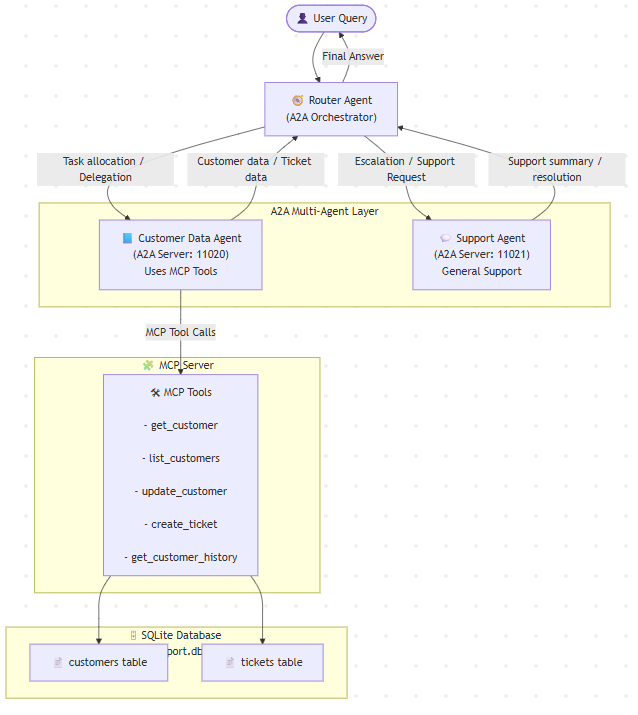

The **Support Agent’s role is simple**:

### **Short answer:**

The **Support Agent** handles all **general customer support conversations**, uses the **context provided by the Router and Customer Data Agent**, and gives **friendly, actionable help** — **but it never calls the MCP server directly**.

It acts like a **frontline support representative** inside my multi-agent system.



* Support Agent **handles general customer support**
* Support Agent **never touches the MCP database directly**
* Support Agent **waits for the Router/Data Agent to provide customer context**
* Support Agent **escalates complex issues when needed**

My current Support Agent matches these requirements perfectly.
